## Missing Non-frauds over Missing Frauds

I will base my model performace and optimisation process into the basic fact that: The business cares more about catching fraudulent transactions over miscounting non-fraud ones, for security and reputation reasons.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("card_transdata.csv")
df = df.rename(columns={'distance_from_home': 'home', 
                        'distance_from_last_transaction': 'trans', 
                        'ratio_to_median_purchase_price': "ratio",
                        'repeat_retailer': "repeat",
                        'used_chip': 'chip',
                        'used_pin_number': 'pin',
                        'online_order': 'online'})

df.head(2)

,home,trans,ratio,repeat,chip,pin,online,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0


In [46]:
# I will use sklean as it provides easy and basic model interpretability.

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score, validation_curve, learning_curve
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.decomposition import PCA as pca

In [16]:
X_train, X_test, y_train, y_test = tts(df.drop(["fraud"], axis=1), df["fraud"])

I will First use a dummy classifier to get a baseline of evaluations.
Secondly I will use techniques like oversampling, undersampling and see how they behave. Then I will look at the confusion matrix and try to optimise my model so that it matches the business requirements (missing non-frauds is better than missing frauds) which is a Recall problem.

In [35]:
# Training the model on one fifth of the datasets for now
model = RandomForest()
model.fit(X_train[:200000], y_train[:200000])

RandomForestClassifier()

In [143]:
# Predicting values
y_pred = model.predict(X_test)

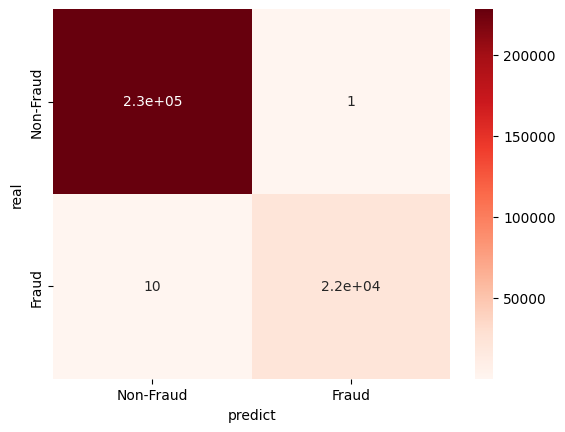

In [43]:
confusion = confusion_matrix(y_test, y_pred)

sns.heatmap(confusion, annot=True, cmap="Reds", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"]);
plt.xlabel("predict");
plt.ylabel("real");

In [ ]:
# Training the model on one fifth of the datasets for now
model = RandomForest()
model.fit(X_train[:200000], y_train[:200000])

RandomForestClassifier()

In [ ]:
# Predicting values
y_pred = model.predict(X_test)

The goal of this heatmap to see how the model behaves on the testing data. My goal in this jupyter notebook is to minimize the amount of values that are predicted as "non-fraud" but with real values of "fraud", without overfitting.

Therefore I will use the technique of training-validation-testing.

In [53]:
# I will do cross validation on different folds for different measurements
# As mentioned, accuracy is a wrong measure so i won't use it.

new_X = X_train[:10000]
new_y = y_train[:10000]
print(f'Cross-validation score on (Area Under Curve "AUC"): \n{cross_val_score(model, new_X, new_y)}')
print(f'Cross-validation score on (Recall): \n{cross_val_score(model, new_X, new_y, scoring="recall")}')
print(f'Cross-validation score on (Precision): \n{cross_val_score(model, new_X, new_y, scoring="precision")}')
print(f'Cross-validation score on (f1): \n{cross_val_score(model, new_X, new_y, scoring="f1")}')

Cross-validation score on (Area Under Curve "AUC"): 
[0.998  0.998  0.9995 0.9975 0.9995]
Cross-validation score on (Recall): 
[0.98369565 0.98369565 0.99456522 0.97282609 0.99459459]
Cross-validation score on (Precision): 
[1. 1. 1. 1. 1.]
Cross-validation score on (f1): 
[0.98901099 0.99178082 0.9972752  0.9862259  0.99182561]


As seen, the model is already behaving nicely at different parameters which is not the common thing a business context. So I will consider improving the Recall Score over precision while still considering the other metrics.

In [121]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()

X_resampled, y_resampled = ros.fit_resample(new_X, new_y)

In [129]:
res_model = RandomForest()
res_model.fit(X_resampled, y_resampled)

RandomForestClassifier()

In [128]:
print(f'Cross-validation score on (Area Under Curve "AUC"): \n{cross_val_score(res_model, new_X, new_y)}')
print(f'Cross-validation score on (Recall): \n{cross_val_score(res_model, new_X, new_y, scoring="recall")}')
print(f'Cross-validation score on (Precision): \n{cross_val_score(res_model, new_X, new_y, scoring="precision")}')
print(f'Cross-validation score on (f1): \n{cross_val_score(res_model, new_X, new_y, scoring="f1")}')

Cross-validation score on (Area Under Curve "AUC"): 
[0.998  0.998  0.9995 0.9975 0.998 ]
Cross-validation score on (Recall): 
[0.97826087 0.97826087 1.         0.97282609 0.98918919]
Cross-validation score on (Precision): 
[1. 1. 1. 1. 1.]
Cross-validation score on (f1): 
[0.98901099 0.98901099 0.9972752  0.9862259  0.99456522]


The model seems to behave similarly even with resampled datasets. Indicating the the imbalance which is 1 to 9, does not showcase a significant effect on the randomforest model in this hypothetical scenario and credit card transactions dataset. I tried with different max_depth as obtained by the following gridsearch and optimisation metrics, and it still behaves similarly.

In [67]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# The best parameter for max_depth for this gridsearch seems to be 9 or 12
# from this simplified gridsearch, so I will check using a heatmap
# if it is good to use the non-default value of this parameter
grids = {"max_depth": [x for x in range(8, 15)]}

grid_clf = GridSearchCV(model, param_grid = grids, scoring="recall")
grid_clf.fit(new_X, new_y)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [8, 9, 10, 11, 12, 13, 14]},
             scoring='recall')

In [66]:
preds = grid_clf.predict(X_test)
print(f"Testing: {f1_score(y_test, preds)}")
print(cross_val_score(grid_clf, new_X, new_y, scoring="recall"))

Testing: 0.9946769116830216
[0.97826087 0.97826087 1.         0.97282609 0.98378378]


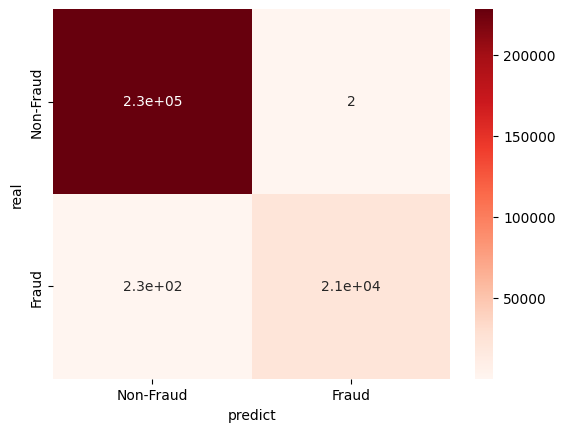

In [68]:
new_confusion = confusion_matrix(y_test, preds)

sns.heatmap(new_confusion, annot=True, cmap="Reds", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"]);
plt.xlabel("predict");
plt.ylabel("real");

This seem to show that using the default value of the decision trees give better results in terms of recall. So i will settle on that for now.

However, I will draw some validation curves to get an understanding of how the model behaves for different parameters.

If i had been put in different conditions where the dataset has a high number of features I would use these methods on other important parameters like n_estimators, or max_features. But this dataset already has enough, meaningful features and the default value for estimators works fine.

In [87]:
train_scores, test_scores = validation_curve(
    RandomForest(),
    new_X, new_y,
    param_name="max_depth",
    param_range=np.arange(5, 15, 1),
    cv=5,
    scoring="recall"
)

In [108]:
param_range = np.arange(5, 15, 1)
mean_trains = np.mean(train_scores, axis=1)
std_trains = np.std(train_scores, axis=1)

mean_tests = np.mean(test_scores, axis=1)
std_tests = np.std(test_scores, axis=1)

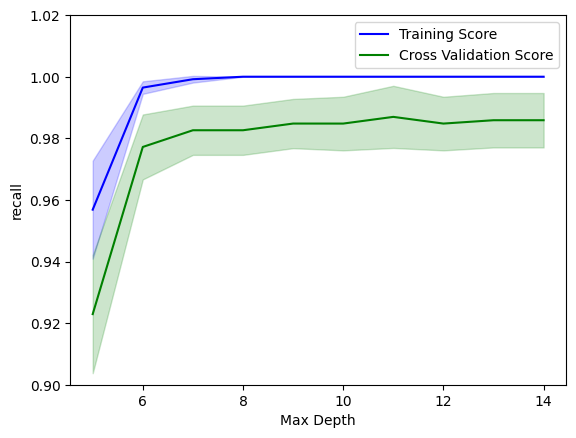

In [112]:
plt.plot(param_range, mean_trains, label="Training Score", color='b')
plt.plot(param_range, mean_tests, label="Cross Validation Score", color='g')

plt.fill_between(param_range, mean_trains - std_trains, mean_trains + std_trains, alpha=0.2, color='blue')
plt.fill_between(param_range, mean_tests - std_tests, mean_tests + std_tests, alpha=0.2, color='green')

plt.xlabel("Max Depth")
plt.ylabel("recall")
plt.ylim(0.9, 1.02)
plt.legend();

This seems to have an okay value after max depth of 7

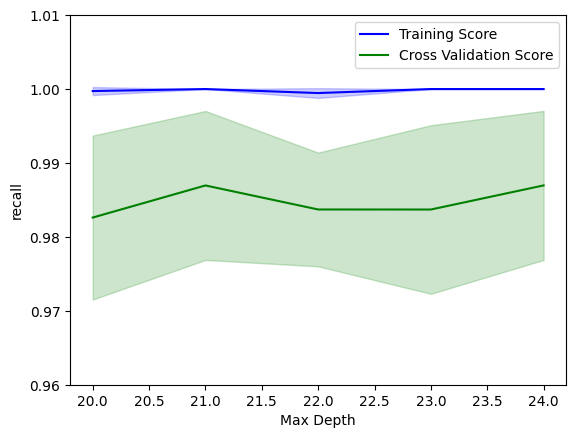

In [142]:
# Using the same code for different values gridSearch

param_range = np.arange(20, 25, 1)

train_scores, test_scores = validation_curve(
    RandomForest(),
    new_X, new_y,
    param_name="n_estimators",
    param_range=param_range,
    cv=5,
    scoring="recall"
)

mean_trains = np.mean(train_scores, axis=1)
std_trains = np.std(train_scores, axis=1)

mean_tests = np.mean(test_scores, axis=1)
std_tests = np.std(test_scores, axis=1)

plt.plot(param_range, mean_trains, label="Training Score", color='b')
plt.plot(param_range, mean_tests, label="Cross Validation Score", color='g')

plt.fill_between(param_range, mean_trains - std_trains, mean_trains + std_trains, alpha=0.2, color='blue')
plt.fill_between(param_range, mean_tests - std_tests, mean_tests + std_tests, alpha=0.2, color='green')

plt.xlabel("Max Depth")
plt.ylabel("recall")
plt.ylim(0.96, 1.01)
plt.legend();

I will now try to estimate the best number of n_estimators, even though it wouldn't affect this project since the dataset is for a situation that is considered almost near-perfect, since not much cleaning and choosing of features happened beforehand.

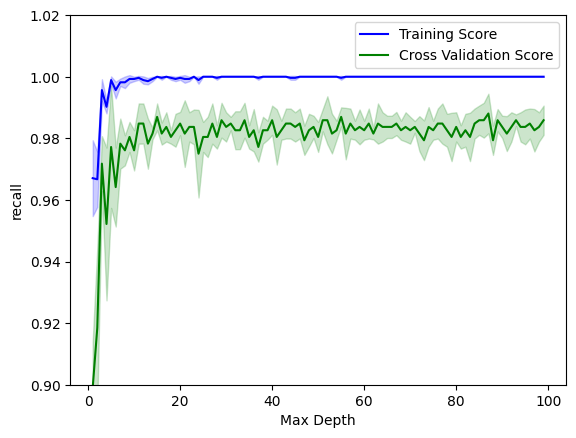

In [117]:
# Using the same code for different values gridSearch

param_range = np.arange(1, 100, 1)

train_scores, test_scores = validation_curve(
    RandomForest(),
    new_X, new_y,
    param_name="n_estimators",
    param_range=param_range,
    cv=4,
    scoring="recall",
    n_jobs=-1
)

mean_trains = np.mean(train_scores, axis=1)
std_trains = np.std(train_scores, axis=1)

mean_tests = np.mean(test_scores, axis=1)
std_tests = np.std(test_scores, axis=1)

plt.plot(param_range, mean_trains, label="Training Score", color='b')
plt.plot(param_range, mean_tests, label="Cross Validation Score", color='g')

plt.fill_between(param_range, mean_trains - std_trains, mean_trains + std_trains, alpha=0.2, color='blue')
plt.fill_between(param_range, mean_tests - std_tests, mean_tests + std_tests, alpha=0.2, color='green')

plt.xlabel("Max Depth")
plt.ylabel("recall")
plt.ylim(0.9, 1.02)
plt.legend();

It looks like that from around 20 trees all numbers start acting the same so using these facts. Now, I'm left with learning curves to see how the dataset affect those different parameters and the training proportion to make use of the computational capacity.

In [134]:
from sklearn.model_selection import LearningCurveDisplay

new_model = RandomForest(max_depth=7, n_estimators=19)

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(new_model, df.drop(["fraud"], axis=1), df["fraud"], return_times=True)

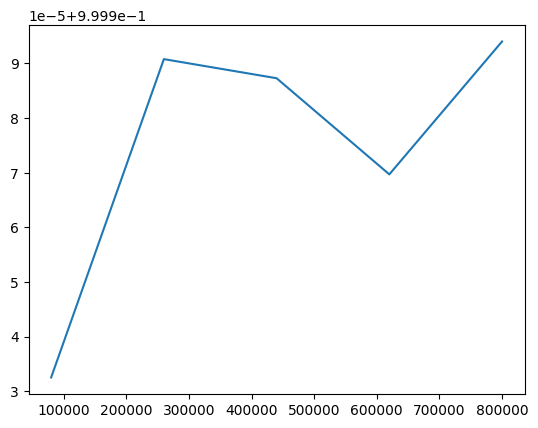

In [136]:
plt.plot(train_sizes, np.mean(train_scores, axis=1));

This Learning Curve Here Shows that for the non-default parameterslly trainign around 800k is good or training around 250k which is 80% and 25% respectfully. Depending on the computational capacity available, the decision therefore changes. However, in my case, I will use around 75% of training and 25% testing, which is the default to:
 1) avoide overfitting
 2) have good presentable results

I will now emphasize on this learning curve and plot a few more with different parameters, just to make sure of my choice.

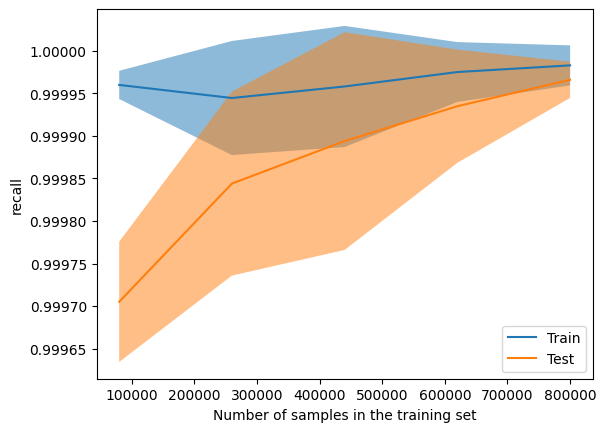

In [138]:
LearningCurveDisplay.from_estimator(estimator=new_model, X=df.drop(["fraud"], axis=1), y=df["fraud"], 
            train_sizes=np.linspace(0.1, 1.0, 5),
            std_display_style="fill_between",
            score_name="recall")

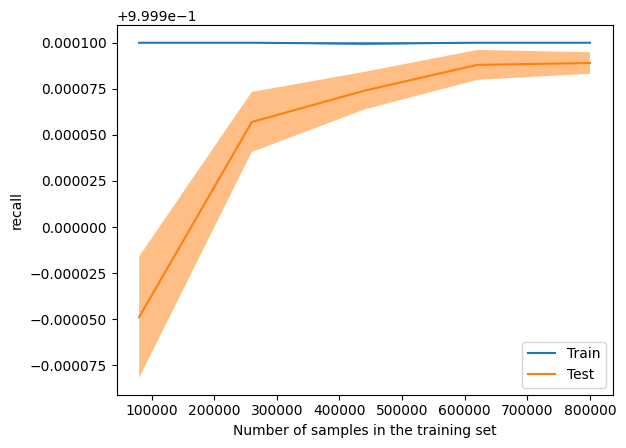

In [140]:
another_model = RandomForest(max_depth=12, n_estimators=30)
LearningCurveDisplay.from_estimator(estimator=another_model, X=df.drop(["fraud"], axis=1), y=df["fraud"], 
            train_sizes=np.linspace(0.1, 1.0, 5),
            std_display_style="fill_between",
            score_name="recall")

From here, I can say that most of the important information required for me to choose a "best-fit" model is present.

However, as i mentioned earlier, I expected to use the default parameters of an ensemble of decision trees using randomforest classifier, and this is what I'm going to perform next as a final model.

The rest of the given timeline for this project will be spent on analytical reporting and gathering evidence on how to use such information to develop solutions to deal with fradulent data. Plus I will document my learning now.

In [155]:
final_X_train, final_X_test, final_y_train, final_y_test = tts(df.drop(["fraud"], axis=1), df["fraud"], train_size=0.8)

In [156]:
# Training the model on one fifth of the datasets for now
final_model = RandomForest()
final_model.fit(final_X_train, final_y_train)

final_y_pred = model.predict(final_X_test)

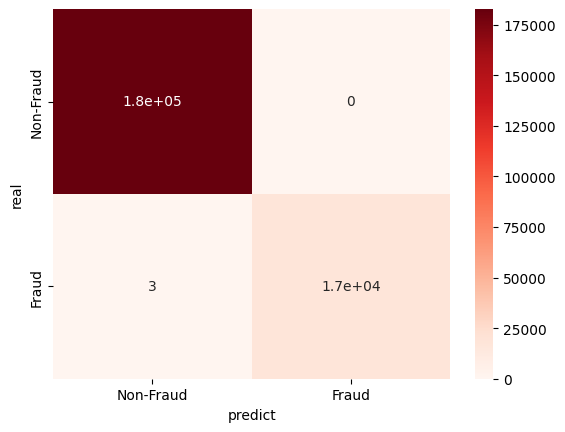

In [161]:
final_confusion = confusion_matrix(final_y_test, final_y_pred)

sns.heatmap(final_confusion, annot=True, cmap="Reds", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"]);
plt.xlabel("predict");
plt.ylabel("real");

In [162]:
print(f1_score(final_y_test, final_y_pred))

0.9999136367561966


This heatmap, at a glance, can be said to show that our model was a somewhat good model to some extent. Although it's prioritising precision over recall, given the above metrics and evaluations, in addition to -if given- high computational power and capacity, we can optimise it to prioritise recall even more than it is good right now. Next I will look at the given information and evidence and report the best practices to ensure security and reputation for the business in a real-world corporate context.